In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import itertools
import os

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


In [2]:
device = torch.device("cuda")

In [3]:
labels = [item for item in os.listdir("data/kth_dataset") if os.path.isdir(os.path.join("data/kth_dataset", item))]


In [4]:
data_dict = np.load("data\kth_dataset\processed_data.npz")
combined_data = []
combined_labels = []

# Loop through the dictionary to combine data and labels
for label, data_array in data_dict.items():
    # Append the data array entries to all_data
    combined_data.append(data_array)  # Keeps the (num_entries, 4, width, height) shape
    
    # Create a list of labels for each entry in this data_array and extend all_labels
    combined_labels.extend([label] * data_array.shape[0])

del(data_array)
# Concatenate all data along the first axis to create a single numpy array
combined_data = np.concatenate(combined_data, axis=0)  # Shape: (total_entries, 4, width, height)
combined_labels = np.array(combined_labels)             # Shape: (total_entries,)


# Convert each label in combined_labels to its corresponding index
label_indices = [labels.index(label) for label in combined_labels]

# Create a one-hot encoded array using np.eye
num_classes = len(labels)
one_hot_labels = np.eye(num_classes)[label_indices]  # Shape: (total_entries, num_classes)




indices = np.random.permutation(combined_data.shape[0])
shuffled_data = combined_data[indices]
shuffled_labels = one_hot_labels[indices]
del(combined_data, combined_labels, one_hot_labels, data_dict, label_indices, indices)

print("Combined data shape:", shuffled_data.shape)
print("Combined labels shape:", shuffled_labels.shape)

Combined data shape: (75854, 30, 40)
Combined labels shape: (75854, 6)


In [5]:
np.unique(shuffled_data)

array([0.000e+00, 1.000e+00, 1.000e+01, 1.100e+01, 1.000e+02, 1.010e+02,
       1.100e+02, 1.110e+02, 1.000e+03, 1.001e+03, 1.010e+03, 1.011e+03,
       1.100e+03, 1.101e+03, 1.110e+03, 1.111e+03])

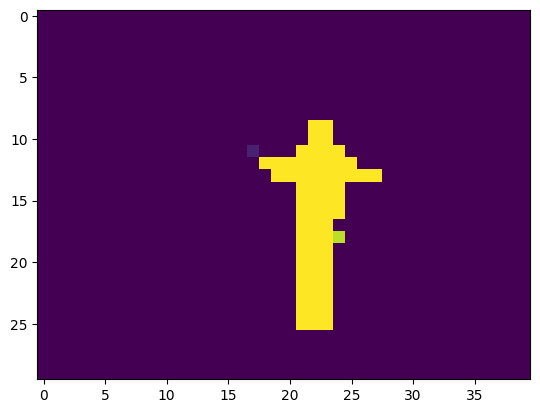

In [6]:
img = shuffled_data[900]

plt.imshow(img)

In [7]:
# Define the split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

# Total number of entries
total_entries = shuffled_data.shape[0]

# Calculate split indices
train_end = int(total_entries * train_ratio)
val_end = train_end + int(total_entries * val_ratio)

# Split the data and labels
train_data = shuffled_data[:train_end]
train_labels = shuffled_labels[:train_end]

val_data = shuffled_data[train_end:val_end]
val_labels = shuffled_labels[train_end:val_end]

test_data = shuffled_data[val_end:]
test_labels = shuffled_labels[val_end:]

del(shuffled_data, shuffled_labels)

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: (56890, 30, 40)
Train labels shape: (56890, 6)
Validation data shape: (7585, 30, 40)
Validation labels shape: (7585, 6)
Test data shape: (11379, 30, 40)
Test labels shape: (11379, 6)


In [8]:
# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [9]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)
    combined_tables.append(combined_table)
    del(df, tables, combined_table)

combined_tables[1] = combined_tables[1].reindex(columns=combined_tables[0].columns)

In [10]:
NUMBER_OF_MASKS = 2
optical_range = np.array([0, 1, 2])  # Optical masks: 0, 1, 2
electrical_range = np.array([0, 1, 2, 3])  # Electrical masks: 0, 1, 2, 3

# Generate a meshgrid of all combinations, so that we don't sample same pair twice
optical_masks, electrical_masks = np.meshgrid(optical_range, electrical_range, indexing='ij')
all_pairs = np.column_stack((optical_masks.ravel(), electrical_masks.ravel()))

unique_indices = np.random.choice(all_pairs.shape[0], size=NUMBER_OF_MASKS, replace=False)

selected_pairs = all_pairs[unique_indices]
optical_masks = selected_pairs[:, 0]
electrical_masks = selected_pairs[:, 1]


# Use this to override previous values,  if you want a specific set of masks
# optical_masks = np.array([0, 1, 2])
# electrical_masks = np.array([0, 1, 2])

# Device masks

number_of_devices = np.multiply(*train_data.shape[-2:])

# device_mask = np.random.randint(0, 5, (NUMBER_OF_MASKS, number_of_devices))

device_mask = np.ones((NUMBER_OF_MASKS, number_of_devices))



In [11]:
print(optical_masks, electrical_masks, device_mask.shape)

[2 0] [3 3] (2, 1200)


In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataset:np.array, 
                 labels:np.array, 
                 combined_tables:np.array, 
                 optical_masks:np.array, 
                 electrical_masks:np.array, 
                 device_mask:np.array):
        self.processed_data = []
        self.labels = []

        for idx in tqdm(range(len(dataset))):
            image, label = dataset[idx], labels[idx]
            # image = (
            #     images[0]*1000+
            #     images[1]*100+
            #     images[2]*10+
            #     images[3]
            # )
            image = image.flatten()
            
            column_indices = combined_tables[0].columns.get_indexer(image.tolist())
            x = []
            for j, (optical_mask, electrical_mask) in enumerate(zip(optical_masks, electrical_masks)):
                required_table = combined_tables[optical_mask].iloc[electrical_mask*5:(electrical_mask+1)*5].iloc[device_mask[j]]
                # print(required_table.shape)

                # to_add = required_table.values[np.arange(device_mask.shape[-1]), column_indices]*1e9

                # plt.imshow(to_add.reshape(43, 54))

                # print(y)

                x.append(required_table.values[np.arange(device_mask.shape[-1]), column_indices]*1e9)
            
            x = np.concatenate(x, axis=0)

            # print(y)
            
            self.processed_data.append(x)
            self.labels.append(label)

        
        
        self.processed_data = torch.tensor(self.processed_data).to(device=device)
        self.labels = torch.tensor(self.labels).to(device=device)

    
    def __len__(self):
        return self.processed_data.shape[0]

    def __getitem__(self, idx):
        return self.processed_data[idx], self.labels[idx]
    
# train_dataset = CustomDataset(train_data, train_labels, combined_tables, optical_masks, electrical_masks, device_mask)

    
    

In [13]:
combined_tables[0].columns

Index([1000,  100,   10,    1, 1100,  110, 1010, 1001,  101,   11, 1110, 1101,
       1011,  111, 1111,    0],
      dtype='int64')

In [14]:

BATCH_SIZE = 2048
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, len(labels))
        self.activation = nn.functional.relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        x = self.softmax(x)
        # x = x.reshape(BATCH_SIZE, 1, NUMBER_OF_MASKS*144, 180)
        
        # x = self.fc(x)
        return x
    


# class ReadoutLayer(nn.Module):
#     def __init__(self, input_channels:int):
#         super(ReadoutLayer, self).__init__()
        
#         # Define convolutional layers for feature extraction
#         self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # First convolutional layer
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Second convolutional layer
        
#         # Fully connected layer for classification (after flattening the output from conv layers)
#         self.fc = nn.Linear(64 * 36 * 45, 10)  # Adjust this depending on the dimensions after convolution

#     def forward(self, x):
#         # Reshape the input to (BATCH_SIZE, input_channels, height, width)
#         x = x.reshape(BATCH_SIZE, 1, NUMBER_OF_MASKS * 144, 180)
        
#         # Apply the first convolutional layer with ReLU activation
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)  # Apply max pooling to downsample
        
#         # Apply the second convolutional layer with ReLU activation
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)  # Apply max pooling to downsample
        
#         # Flatten the output to feed into the fully connected layer
#         x = x.view(x.size(0), -1)  # Flatten the tensor
        
#         # Pass through the fully connected layer for classification
#         x = self.fc(x)
        
#         return x


In [15]:
train_dataset = CustomDataset(train_data, train_labels, combined_tables, optical_masks, electrical_masks, device_mask)
validation_dataset = CustomDataset(val_data, val_labels, combined_tables, optical_masks, electrical_masks, device_mask)
test_dataset = CustomDataset(test_data, test_labels, combined_tables, optical_masks, electrical_masks, device_mask)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



100%|██████████| 56890/56890 [00:29<00:00, 1953.22it/s]
C:\Users\adith\AppData\Local\Temp\ipykernel_46404\2448274079.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.processed_data = torch.tensor(self.processed_data).to(device=device)
100%|██████████| 11379/11379 [00:05<00:00, 1946.92it/s]


In [16]:
train_dataset[0][0].shape

torch.Size([2400])

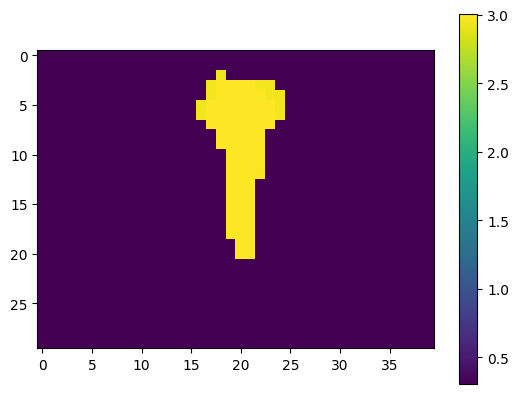

In [17]:
imgs = train_dataset[128][0].reshape(NUMBER_OF_MASKS, 30, 40).cpu()

plt.imshow(imgs[0])
plt.colorbar()

In [18]:

EPOCHS = 1000
learning_rate = 0.001

model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=len(labels)).to(device)
precision = Precision(task="multiclass", num_classes=len(labels), average='macro').to(device)
recall = Recall(task="multiclass", num_classes=len(labels), average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=len(labels), average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=len(labels)).to(device)

In [19]:
for epoch in range(EPOCHS):
    model.train()
    running_loss, batch_count = 0.0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images.float())  # Forward pass
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        running_loss += loss.item()
        batch_count += 1
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images, labels
            outputs = model(images.float())
            preds = outputs.argmax(dim=1)
            labels = labels.argmax(dim=1)
            # Update metrics
            # print(preds.shape, labels.shape)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%10 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/batch_count:.6f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().max().item():.4f} Precision: {precision.compute().max().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().max().item():.4f} F1 Score: {f1_score.compute().max().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [10/1000], Loss: 1.502853 Validation - Accuracy: 0.5540 Precision: 0.3845  Recall: 0.4649 F1 Score: 0.4142
Epoch [20/1000], Loss: 1.482811 Validation - Accuracy: 0.5699 Precision: 0.3962  Recall: 0.4798 F1 Score: 0.4260
Epoch [30/1000], Loss: 1.473927 Validation - Accuracy: 0.5742 Precision: 0.3972  Recall: 0.4823 F1 Score: 0.4293
Epoch [40/1000], Loss: 1.468438 Validation - Accuracy: 0.5753 Precision: 0.3990  Recall: 0.4842 F1 Score: 0.4299
Epoch [50/1000], Loss: 1.464424 Validation - Accuracy: 0.5798 Precision: 0.4035  Recall: 0.4880 F1 Score: 0.4337
Epoch [60/1000], Loss: 1.461683 Validation - Accuracy: 0.5822 Precision: 0.4052  Recall: 0.4905 F1 Score: 0.4352
Epoch [70/1000], Loss: 1.459356 Validation - Accuracy: 0.5819 Precision: 0.4039  Recall: 0.4897 F1 Score: 0.4351
Epoch [80/1000], Loss: 1.457292 Validation - Accuracy: 0.5830 Precision: 0.4042  Recall: 0.4907 F1 Score: 0.4358
Epoch [90/1000], Loss: 1.455189 Validation - Accuracy: 0.5817 Precision: 0.4046  Recall: 0.4902 

In [21]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels

all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)
all_labels = all_labels.argmax(dim=1)
# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')
print("Confusion Matrix:")
print(test_confusion_matrix)

        

C:\Users\adith\AppData\Local\Temp\ipykernel_46404\227308190.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 62.81%
Test Precision: 44.0218%
Test Recall: 53.1435%
Test F1 Score: 0.4725
Confusion Matrix:
tensor([[8996,  658,  844,    0,    0,  373],
        [ 842, 8591,  910,    0,    0,  178],
        [1379, 2284, 8382,    0,    0,  822],
        [ 611,   98,  335,    0,    0, 5745],
        [ 406,   79,  270,    0,    0, 4152],
        [ 661,  128,  380,    0,    0, 9766]], device='cuda:0')
